# Country V.S. Hip-Hop Classification

### Author: Kevin Marroquin

This project will consist of creating a classifier to predict whether a song's genre is either country or hip-hop using a k-nearest neighbor (KNN) classifier. I will implement these methods from scratch followed by a comparison using Sklearn. The entirety of this notebook is constructed by me except where noted.

#### Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#Make screen bigger horizontally
from IPython.core.display import display, HTML
display(HTML("<style> *{margin:0; padding:0;} \
html, body, .container{margin:0;!important padding:0;!important} \
.container { width:100% !important;}</style>"))

## Exploring the Data

This dataset was extracted from the [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) by the Division of Data Science at UC Berkeley. Specifically, they have merged datasets from [musiXmatch](http://labrosa.ee.columbia.edu/millionsong/musixmatch) and [Last.fm](http://labrosa.ee.columbia.edu/millionsong/lastfm). 

In [2]:
#Loading and observing the shape of the data
lyrics = pd.read_csv("lyrics.csv")
print(lyrics.shape)
lyrics.head()

(1721, 4820)


,Title,Artist,Genre,i,the,you,to,and,a,me,...,seventh,capit,writer,motivo,bake,insist,santo,pe,gee,colleg
0,Slicker Than Your Average,Craig David,Hip-hop,0.049536,0.017028,0.035604,0.020124,0.007740,0.006192,0.058824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Right There,MF Grimm,Hip-hop,0.037825,0.054374,0.023641,0.049645,0.009456,0.016548,0.018913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Talkin' All That,Cashis,Hip-hop,0.056738,0.049645,0.051418,0.010638,0.026596,0.033688,0.007092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,It Only Hurts Me When I Cry,Raul Malo,Country,0.096491,0.074561,0.030702,0.017544,0.026316,0.017544,0.021930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Is It Too Late Now,Lester Flatt & Earl Scruggs,Country,0.043902,0.000000,0.073171,0.019512,0.000000,0.014634,0.034146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The first three columns contain information about a song. The rest contain the proportion of word contained in a song's lyrics. There are about 4817 words in these 
songs, some more prominent in country songs than hip-hop, and vice-versa. 

As a check, I'd like to make sure that the numbers in a row all sum to 1 to see if any additional cleaning is needed.

In [3]:
#Finding there are many unique values in dataset 
len(set(np.sum(lyrics, axis = 1)))

545

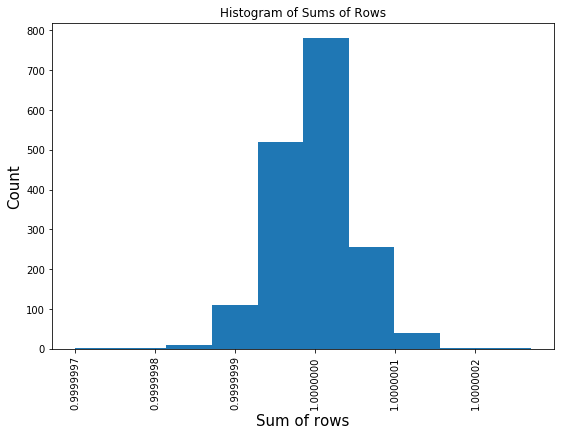

In [4]:
#Checking whether numbers in a row sum to 1
plt.figure(figsize=(9, 6))
plt.hist(np.sum(lyrics, axis = 1))
plt.title("Histogram of Sums of Rows")
plt.xticks(rotation = 90)
plt.xlabel("Sum of rows", size = 15)
plt.ylabel("Count", size = 15)
plt.ticklabel_format(useOffset=False)
plt.show()

An assumption we're going to have to make is that most of our values approach 1. A reasonable guess for this error could be that numerical values representing irrational numbers (1/3, 1/7, etc.) do not perfectly sum up to 1 on a computer. Still, this error is small and assuming that these values approach 1 is good enough.

Next, We're going to have to explore how word stemming influences our data. musiXmatch, one of our resources for our current dataset, specifically uses this to categorize similar words together (e.g. transports, transporting, and transported all stem from transport). This however has its flaws, as certain words may be contained as a compound (e.g. transport is a compound of transportation). Let's load one of the datasets obtained having these stemmed words.

In [5]:
stemDF = pd.read_csv("mxm_reverse_mapping_safe.csv")
stemDF.head()

,Stem,Word
0,día,día
1,pido,pido
2,hatr,hatred
3,pide,pide
4,yellow,yellow


We note that some stems are at times the word itself. Above we see *pide* and *yellow* as both stem and words.

Let's extract the stems we need in `lyrics`.

In [6]:
print("Words in lyrics df:", len(lyrics.columns[3:]))
print("Stems in stemDF:", len(stemDF))

Words in lyrics df: 4817
Stems in stemDF: 4976


In [7]:
#Gathering list of stems
stems = list(set(list(stemDF['Stem'])).intersection(lyrics.columns[3:]))
len(stems)

4817

`stems` being the same size as lyrics, let's leave values in `stemDF` that are in `stems`.

In [8]:
#Running more than once will not make changes to stemDF unless original CSV is
#loaded again
stemDF = stemDF[
    [True if stem in stems else False for stem in stemDF['Stem']]
]
stemDF.shape

(4817, 2)

We now have a dataframe of stems corresponding to a specific word.

## K-Nearest Neighbors From Scratch

I will now be making a KNN model from scratch. First, I will create a list of words and use them as my features. Then, I'll make a classifier model that requires one test datum. After extending it to accept multiple test data, I will create a all in one function to train with training data and accept test data, giving a list of guesses.

In [9]:
#Setting my_20_features to an array of 20 features (strings that are column labels)
my_20_features = np.array(['countri', 'fight', 'sweet', 'nice', 'drink', 
                           'weak', 'over', 'home', 'friend', 'wanna', 'leav', 
                           'never', 'back', 'heart', 'around', 
                           'know','down', 'life', 'ya', 'yo'])

In [429]:
#Creating sample
rand_sam = np.arange(len(lyrics))
np.random.shuffle(rand_sam)

#Breaking up my data 75-25% split
split_pt = int(np.round(len(lyrics) * 0.75))
lyrics_train = lyrics.iloc[rand_sam[:split_pt], :]
lyrics_test = lyrics.iloc[rand_sam[split_pt:], :]
print("Train shape:", lyrics_train.shape)
print("Test shape:", lyrics_test.shape)

Train shape: (1291, 4820)
Test shape: (430, 4820)


In [430]:
#Gathering 20 features
train20 = lyrics_train.loc[:, my_20_features]
test20 = lyrics_test.loc[:, my_20_features]

In [431]:
#UC Berkeley's Data 8 fast_distance function
def fast_distances(test_row, train_rows):
    """An array of the distances between test_row and each row in train_rows.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test song (e.g., test_20.iloc[0, :]).
      train_rows: A table of features (for example, the whole
        table train_20).
        
    Returns distance array of valures from test row and all of the train rows
    """
    counts_matrix = np.asmatrix(train_rows)
    diff = (
        np.tile(np.array(test_row), [counts_matrix.shape[0], 1]) - 
        counts_matrix
    )
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    return distances

In [432]:
#Creating pandas dataframe to put values in with trained
distance = pd.DataFrame({"label": lyrics_train.Genre,
                         "distance":fast_distances(test20.iloc[0, :], train20)
})

#Sorting
distance.sort_values("distance", inplace=True)

In [433]:
#Gathering the 5 nearest neighbors 
def freqValue(df, label = "label", num_neighbor = 7):
    """Returns the most frequent value in a column
    
    Arguments:
        df - DataFrame of values
        label (optional) - Name of column to find data
        num_neighbors (optional) - Number of k neighbors
    """
    from collections import Counter
    
    #Dictionary giving labels in label (keys) and their frequency (values)
    x = dict(Counter(
        df.iloc[:num_neighbor, :].loc[:,label]
    ))
    return max(x, key=lambda i: x[i])

In [434]:
#Predicted value
freqValue(distance)

'Country'

In [435]:
#Actual value
lyrics_test.iloc[0, 2]

'Country'

Above shows an example of training data and predicting with one example. The predicted value from the algorithm is correct, predicting the actual value.

Let's try with more than one example and see how accurate the above code is. Since my piece of code is quite large for a jupyter cell, I've created a .py file containing a modified version of the process above. Please refer to the .py file for more information on how the following code works.

In [436]:
from kNN_Homemade import knnModel

In [437]:
#Loading basic model
model = knnModel()

#Training and testing data
train_data, test_data = model.train_test_split(lyrics, 0.75, my_20_features)

#Training and predicting data
model.train(train_data)
predictions_train = model.predict(train_data)
predictions_train.head()

259     Hip-hop
1180    Country
169     Hip-hop
1291    Country
655     Hip-hop
dtype: object

In [438]:
print("Train accuracy:", model.score("Genre"))

Train accuracy: 0.8350116189000775


Not bad, scoring around 80% accuracy. Let's see if we predict using our test data.

In [439]:
#Loading basic model
model = knnModel()

#Training and testing data
train_data, test_data = model.train_test_split(lyrics, 0.75, my_20_features)

#Training and predicting data
model.train(train_data)
model.predict(test_data)
print("Test accuracy:", model.score("Genre"))

Test accuracy: 0.7837209302325582


Let's now compare our results to sklearn's version of the algorithm. Since their version of the algorithm is more robust, I'm expecting a higher accuracy.

## SciKit Learn Implementation and Comparison

In [440]:
from sklearn.neighbors import KNeighborsClassifier

In [441]:
#Loading sklearn's kNN classifier and assigning predictions
modelSK = KNeighborsClassifier(n_neighbors = 7)
modelSK.fit(train20, lyrics_train['Genre'])
predictionsSK = modelSK.predict(train20)

#Loading first 5 values in predictions
predictionsSK[:5]

array(['Hip-hop', 'Country', 'Country', 'Country', 'Country'],
      dtype=object)

In [442]:
#Scoring 
print("Train accuracy:", modelSK.score(train20, lyrics_train["Genre"]))

Train accuracy: 0.8094500387296669


Now let's see for testing data

In [443]:
#Assigning test predictions and scoring
modelSK = KNeighborsClassifier(n_neighbors = 7)
modelSK.fit(train20, lyrics_train['Genre'])
predictionsSK = modelSK.predict(test20)
print("Test accuracy:", modelSK.score(test20, lyrics_test["Genre"]))

Test accuracy: 0.8209302325581396


## Comparison and Remarks

Both models are overfitting, with the homemade model overfitting more. Yet the homemade model is giving a higher accuracy overall, surprisingly. Not to say our model is better than Sklearn's, but it works well on it's own.

To find what works best, I've created a group of words that best give high accuracies to both models. Both models score a max ~82%, with an occasional overfitting pattern (max and rarely 10%). Both models tend to perform equally, sometimes iterations will produce low and overfitting results, other times not. Below is the work I used to run everything

In [447]:
#Setting my_new_features to an array of new features
my_new_features = np.array(["cri", "old", "gone", "well",
                           'weak', 'over', 'long','heart', 'ya', 
                           'yo', "away", "en", "des"])

In [448]:
#Function to compare Genre's with their mean values
lyrics.groupby(["Genre"]).mean()["em"]

Genre
Country    0.000412
Hip-hop    0.001324
Name: em, dtype: float64

In [449]:
#Gathering new mean values for each word. Takes a little under a minute to run
val_means = lyrics.iloc[:, 3:].mean(axis = 0).sort_values(ascending=False)[:200]
val = []
for word in val_means.index:
    temp = lyrics.groupby(["Genre"]).mean()[word]
    val.append(np.abs(temp["Country"] - temp["Hip-hop"]) / (temp["Country"] + temp["Hip-hop"]))

In [450]:
pd.DataFrame({"Avg Val": lst}, index = tester.index).sort_values(by = "Avg Val", ascending = False).head()

,Avg Val
des,1.0
je,1.0
ich,1.0
du,1.0
et,1.0


Observing above, words in different languages tend to lean more one genre (from exploring, it looks like Hip-hop).

In [455]:
pd.DataFrame({"Avg Val": lst}, index = tester.index).sort_values(by = "Avg Val", ascending = False)[30:35]

,Avg Val
home,0.548895
littl,0.535674
rain,0.527649
left,0.527317
em,0.525333


These are sample words giving the biggest difference between each other with respect to their size.

## Conclusion

Throughout this notebook I've analyzed and fidged with my dataset, looking for trends and assumptions I may make about my data. I've implemented my very own kNN algorithm and through multiple trial and error comparisons (not shown, see code in Comparison and Remarks), I was able to conclude that my algorithm works similarly to Sklearn's implementation. In the process I was able to make a last minute revelations about the data: most words in a different language belong to a certain genre, that being *Hip-hop*. Had I more time I would have experimented more on this lead to pursue a higher accuracy however with the homemade kNN algorithm built my main objective is complete.